In [149]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from matplotlib.colors import ListedColormap

from Data import Data

In [151]:
data = Data()
columns = ["rrTime" + str(index) for index in range(15)]
columns.extend(["ppTime" + str(index) for index in range(15)])
columns.extend(["rpTime" + str(index) for index in range(15)])
columns.extend(["prTime" + str(index) for index in range(15)])

#xx, yy = np.meshgrid(np.linspace(-1, 1, 500), np.linspace(-1, 1, 500))
xx, yy = np.meshgrid(np.arange(start=X_train.min() - 1, stop=X_train.max() + 1, step=0.01), np.arange(start=X_train.min() - 1, stop=X_train.max() + 1, step=0.01))
Xpred = np.array([xx.ravel(), yy.ravel()] + [np.repeat(0, xx.ravel().size) for _ in range(58)]).T

user_index = 1

In [152]:
studiedUserData = data.table.loc[(data.table["user_id"] == user_index), columns].astype('float')
studiedUserMsk = np.random.rand(len(studiedUserData)) < 0.8
otherUsersData = data.table.loc[(data.table["user_id"] != user_index), columns].astype('float')

X_train = studiedUserData[studiedUserMsk]
X_test = studiedUserData[~studiedUserMsk]
X_outliers = otherUsersData
#X_test = pd.concat([studiedUserData[~studiedUserMsk], otherUsersData[:-200]])
#X_outliers = otherUsersData[-200:]

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_outliers = scaler.transform(X_outliers)

In [153]:
# Generate some abnormal novel observations
#X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))

# fit the model
clf = OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
clf.fit(X_train)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)

n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size

In [154]:


# Xpred now has a grid for x1 and x2 and average value (0) for x3 through x13
#pred = clf.predict(Xpred).reshape(xx.shape)   # is a matrix of 0's and 1's !
#plt.contourf(xx, yy, pred, alpha = 0.75, cmap = ListedColormap(('red', 'green')))

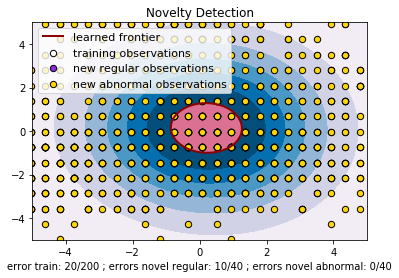

In [155]:
Z = clf.decision_function(Xpred)
Z = Z.reshape(xx.shape)

plt.title("Novelty Detection")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')

s = 40
b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white', s=s, edgecolors='k')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='blueviolet', s=s,
                 edgecolors='k')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='gold', s=s,
                edgecolors='k')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([a.collections[0], b1, b2, c], ["learned frontier", "training observations", "new regular observations", "new abnormal observations"], loc="upper left", prop=matplotlib.font_manager.FontProperties(size=11))
plt.xlabel("error train: %d/200 ; errors novel regular: %d/40 ; errors novel abnormal: %d/40" % (n_error_train, n_error_test, n_error_outliers))
plt.show()